In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline
import cv2
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize
from PIL import Image
import pydot
import os
import glob
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [2]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# # Currently, memory growth needs to be the same across GPUs
# for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
# tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

In [50]:
DROPOUT_RATE = 0.1
FROZEN_LAYER_NUM = 19

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [99]:
vgg_notop = VGGFace(model='vgg16', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
print(vgg_notop.summary())
last_layer = vgg_notop.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)  # ** new
x = Dense(512, activation='relu', name='fc8')(x) # ** new
x = Dropout(0.3)(x) # ** new
x = Dense(128, activation='relu', name='fc9')(x) # ** new

for i in range(FROZEN_LAYER_NUM):
    vgg_notop.layers[i].trainable = False

print(vgg_notop.get_layer('pool5').trainable)

# out = Dense(7, activation='softmax', name='classifier')(x)
out = Dense(1, activation='sigmoid', name='classifier')(x)

model = Model(vgg_notop.input, out)

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 197, 197, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 197, 197, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 197, 197, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 98, 98, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 98, 98, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 98, 98, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 49, 49, 128)     

In [98]:
model.load_weights('d:/VMS/fer2013_Best/cs230-fer-master/cs230-fer-20201217T134248Z-001/cs230-fer/VGG16-AUX-BEST-70.2.h5', by_name=True)

In [82]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 197, 197, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 197, 197, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 197, 197, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 98, 98, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 98, 98, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 98, 98, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 49, 49, 128)       0  

In [2]:
output_path="D:/VMS/del/RAW/"

In [3]:
path = 'd:/VMS/del/Final_with_label_landmark_features_30.csv' # the path where all CSV are saved from part 1
Data_ALL = pd.read_csv(path, sep=',',header=0)

In [4]:
img_name=Data_ALL.iloc[:,137]

In [5]:
img_name

0        P06682_17_06_2019_024317_wc_frame_37.jpg
1        P06682_17_06_2019_024317_wc_frame_47.jpg
2        P06682_17_06_2019_024317_wc_frame_57.jpg
3        P06682_17_06_2019_024317_wc_frame_67.jpg
4       P06682_17_06_2019_024317_wc_frame_137.jpg
                          ...                    
3837    P09966_04_03_2020_163313_wc_frame_256.jpg
3838    P09966_04_03_2020_163313_wc_frame_257.jpg
3839    P09966_04_03_2020_163313_wc_frame_597.jpg
3840    P09966_04_03_2020_163313_wc_frame_598.jpg
3841    P09966_04_03_2020_163313_wc_frame_599.jpg
Name: Name, Length: 3842, dtype: object

In [6]:
img_lable=Data_ALL.iloc[:,140]

In [7]:
img_lable

0       0
1       0
2       0
3       0
4       0
       ..
3837    1
3838    1
3839    0
3840    0
3841    0
Name: eye contact, Length: 3842, dtype: int64

In [8]:
X  = []
y  = []
def images_pre(path):
# the path where all images will be preprocessed 
    all_files = glob.glob(output_path+"/"+path+'/faces/')
    Frames_list=os.listdir(all_files[0])
    Frames_list = sorted(Frames_list, key = lambda x: int(x.split("_")[-1].split(".")[0]))
    #print(len(all_files))
    for filename in Frames_list:
        for xx,yy in zip(img_name,img_lable):
            if xx == filename:
                img_array = cv2.imread(all_files[0]+filename ,1)  # convert to array
                X.append(img_array)  # add this to our training_data
                y.append(yy)


In [9]:
mp4_Frames_Path=os.listdir(output_path)
print ("Total of Dir =" + str(len(mp4_Frames_Path)) )
counter=1
for frmspath in mp4_Frames_Path:  #loop Dir to send to function!
    Folder_name=os.path.splitext(frmspath)[0]
    images_pre(frmspath)
    counter = counter +1

Total of Dir =5


In [10]:
X[50].shape

(197, 197, 3)

In [11]:
X = np.array(X).reshape(-1, 197, 197,3)

In [12]:
imgs_all= X/255.0

In [13]:
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [14]:
y=np.expand_dims(y, axis=1)

In [15]:
# define data
data = asarray([['YES'], ['NO']])
encoder = OneHotEncoder(sparse=False)
#onehot = encoder.fit_transform(data)
onehot = encoder.fit_transform(y)
#print(onehot)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(imgs_all, y, 
                                                    test_size=0.2, random_state=1234,shuffle=True)

In [21]:
y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [100]:
for i in range(27):
    model.layers[i].trainable = False

In [101]:
for i in range(27,29):
    model.layers[i].trainable = True

In [102]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [103]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('D:/VMS/fer2013_Best/cs230-fer-master/test9999.h5', save_best_only=True, monitor='val_loss', mode='min')

In [104]:
history = model.fit(x = X_train, y = y_train,
                     batch_size=256,
                     epochs = 500,
                     validation_split=0.3,
                     use_multiprocessing=True,
                     shuffle=True,
                    callbacks=[earlyStopping, mcp_save]
                   )

Train on 2151 samples, validate on 922 samples
Epoch 1/500
2151/2151 [==============================] - 110s 51ms/step - loss: 0.6878 - accuracy: 0.5583 - val_loss: 0.6788 - val_accuracy: 0.6508
Epoch 2/500
2151/2151 [==============================] - 110s 51ms/step - loss: 0.6726 - accuracy: 0.6983 - val_loss: 0.6638 - val_accuracy: 0.6768
Epoch 3/500
2151/2151 [==============================] - 110s 51ms/step - loss: 0.6545 - accuracy: 0.7146 - val_loss: 0.6467 - val_accuracy: 0.6996
Epoch 4/500
2151/2151 [==============================] - 110s 51ms/step - loss: 0.6339 - accuracy: 0.7248 - val_loss: 0.6297 - val_accuracy: 0.6952
Epoch 5/500
2151/2151 [==============================] - 110s 51ms/step - loss: 0.6163 - accuracy: 0.7127 - val_loss: 0.6138 - val_accuracy: 0.7126
Epoch 6/500
2151/2151 [==============================] - 110s 51ms/step - loss: 0.5981 - accuracy: 0.7187 - val_loss: 0.5998 - val_accuracy: 0.7104
Epoch 7/500
2151/2151 [==============================] - 110s 51m

In [105]:
def plot_history(history):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'Val'])
    return;

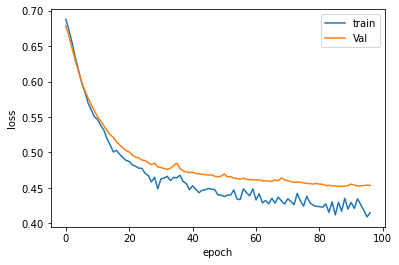

In [106]:
plot_history(history)

In [28]:
from tensorflow import keras
import pylab
# model = keras.models.load_model("D:/VMS/fer2013_Best/cs230-fer-master/eye_contact_4.h5")
model = keras.models.load_model("D:/VMS/fer2013_Best/cs230-fer-master/test999.h5")

In [18]:
y_pred = model.predict(X_test)

In [19]:
y_test_np=np.array(y_test)

In [20]:
y_test_np=y_test_np.reshape(-1,1)

In [21]:
y_pred_np=np.array(y_pred)

In [22]:
y_pred_np=y_pred_np.reshape(-1,1)

In [23]:
Y_pre_final =np.around(y_pred_np, decimals=0, out=None)

In [42]:
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test_np, Y_pre_final)
# print(cm)

In [42]:
# from sklearn.metrics import confusion_matrix
# from seaborn import heatmap
# import pylab
# from matplotlib import pyplot
# emotions = {0:'NO', 1:'YES'}

# cmat_df_test=pd.DataFrame(confusion_matrix(y_test_np, Y_pre_final, normalize='true').round(2),index=emotions.values(), columns=emotions.values())

# plt.figure(figsize=(5,5))
# heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
# plt.tight_layout()
# plt.title('Confusion Matrix For eye Contace')
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

E:\Users\sodic\miniconda3\envs\tensor_CPU\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Eye Contact Normalized Confusion Matrix')

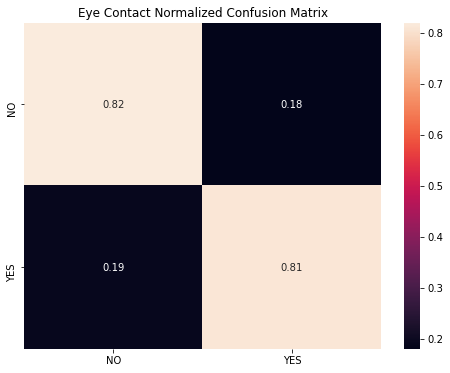

In [126]:
import seaborn as sns
conf_mat = pd.DataFrame(confusion_matrix(y_test_np, Y_pre_final, normalize='true').round(2),index=emotions.values(), columns=emotions.values())

conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] #Normalisation Happens here

df_cm = pd.DataFrame(conf_mat, index = emotions.values(),
                     columns = emotions)
plt.figure(figsize = (8,6))
sns.heatmap(conf_mat, annot=True, fmt='.2f', xticklabels=emotions.values(), yticklabels=emotions.values())
plt.title('Eye Contact Normalized Confusion Matrix')

In [33]:
ns_probs = [0 for _ in range(len(y_test_np))]

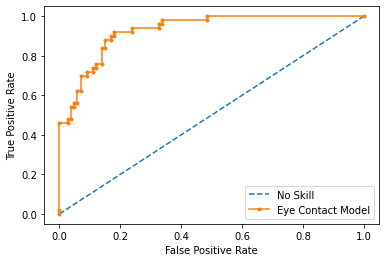

<Figure size 576x432 with 0 Axes>

In [43]:
ns_fpr, ns_tpr, _ = roc_curve(y_test_np, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_np, y_pred_np)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Eye Contact Model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
plt.figure(figsize = (8,6))
pyplot.show()

In [107]:
# convert the history to DataFrame:     
hist_df = pd.DataFrame(history.history) 


hist_csv_file = 'history_Batch_512_Epochs_5099.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [41]:
auc = roc_auc_score(y_test_np, y_pred_np)
print('AUC: %.3f' % auc)

AUC: 0.929
